In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Load + prep data

In [15]:
# Load your full dataset (not the sample)
train = pd.read_csv('train.csv')

# Drop high-cardinality or unhelpful columns
train = train.drop(columns=['id', 'Episode_Title'])

# Drop missing values for now (we can impute later)
train = train.dropna()

# Specify categorical features
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Convert categoricals to 'category' dtype
for col in categorical_cols:
    train[col] = train[col].astype('category')

# Define X and y
X = train.drop(columns=['Listening_Time_minutes'])
y = train['Listening_Time_minutes']


### Create Train test split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Train LightGBM with Native Categoricals

In [23]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Train the model, telling LightGBM which columns are categorical
lgb_model.fit(X_train, y_train, categorical_feature=categorical_cols)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 431238, number of used features: 9
[LightGBM] [Info] Start training from score 45.829445


LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

### Evaluate the Model

In [26]:
# Predict
y_pred_lgb = lgb_model.predict(X_val)

# Evaluate
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)
r2_lgb = r2_score(y_val, y_pred_lgb)

print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"LightGBM MAE: {mae_lgb:.2f}")
print(f"LightGBM R²: {r2_lgb:.4f}")


LightGBM RMSE: 10.40
LightGBM MAE: 8.00
LightGBM R²: 0.8536


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Residual Plot

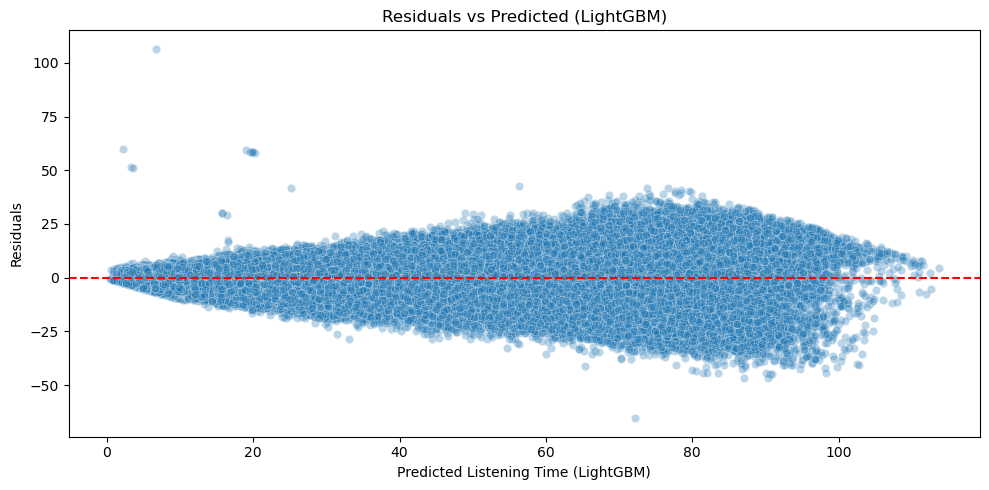

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_lgb = y_val - y_pred_lgb

# Plot residuals vs predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_lgb, y=residuals_lgb, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time (LightGBM)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (LightGBM)')
plt.tight_layout()
plt.show()


### Feature Importances

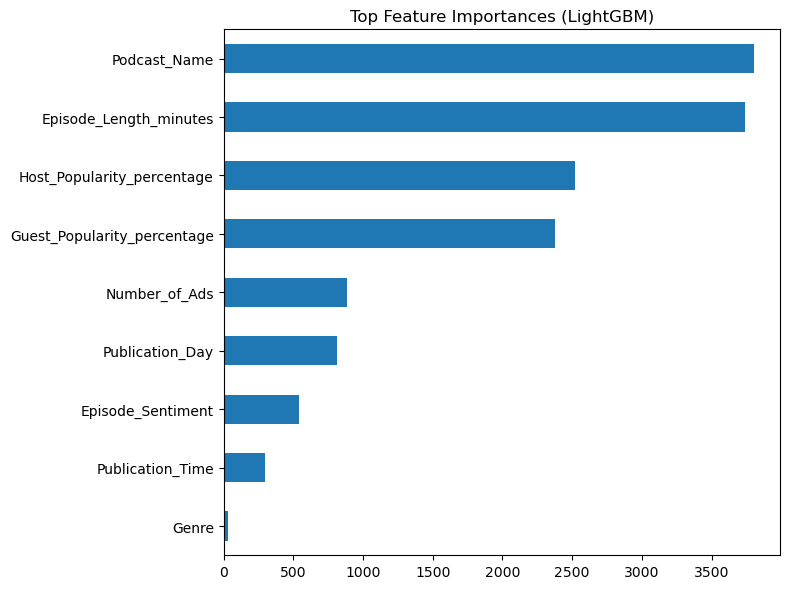

In [32]:
# Get feature importances from trained model
importances = pd.Series(lgb_model.feature_importances_, index=X.columns)

# Sort and plot top 15
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_importances.plot(kind='barh')
plt.title('Top Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### LightGBM with Native Categorical Support

A LightGBM model was trained on the full dataset using native categorical features. Categorical variables were set to `'category'` dtype and passed directly to the model, allowing it to learn category-specific splits efficiently.

#### Performance on Validation Set
- RMSE: 10.40
- MAE: 8.00
- R²: 0.8536

While not quite as low as Random Forest's RMSE on the training set, this model provides a **more realistic generalisation estimate**.

#### Residual Analysis
- Residuals were tightly clustered around zero
- Slight increase in variance for higher predicted values
- No major structural issues — LightGBM captured most non-linearities

#### Feature Importances
- `Podcast_Name` and `Episode_Length_minutes` were by far the most important features
- `Host_Popularity_percentage`, `Guest_Popularity_percentage`, and `Number_of_Ads` showed moderate importance
- Categorical features like `Publication_Day`, `Publication_Time`, and `Episode_Sentiment` contributed meaningfully — much more than when one-hot encoded
- `Genre` had very little predictive value

#### Summary
LightGBM with native categoricals generalises well and captures the majority of important patterns. It outperforms linear regression in both accuracy and feature understanding, while providing clearer, more realistic results than Random Forest (which likely overfit).

This model provides a strong foundation for further tuning, feature engineering, or ensemble methods.
